# Song Genre Classification
## Part 3: Classification
### Basline model: TF-IDF n-grams

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

style.use('seaborn')

In [3]:
data = pd.read_csv('./data.csv')
data.head()

,subset,author,song,genre,lyrics,tokenized,length,tree_depth,ne_ratio,type_token,ngram_ratio,slang,pron_self,pron_first_second,words_length,lines_length,NOUN,VERB,ADJ,PRON,swear_words
0,tr,bob dylan,Black Cross (Live),Folk,This is the story of Hezekiah Jones...\n\nHeze...,This is the story of Hezekiah Jones ... \n\n H...,144,8.000000,0.037879,0.566929,0.809524,0.941176,0.053,0.000,124,11.273,0.096774,0.016129,0.064516,0.153226,1
1,tr,isaiah rashad,unk174,Rap,"My niggas die for it, she got that pussy juice...","My niggas die for it , she got that pussy juic...",107,44.000000,0.018349,0.500000,0.649485,0.911765,0.800,4.000,98,8.167,0.214286,0.081633,0.051020,0.163265,1
2,tr,jamie lawson,a darkness,Pop,"there 's a darkness in between us , a darkness...","there 's a darkness in between us , a darkness...",363,117.000000,0.003390,0.393220,0.603175,0.956522,1.000,1.000,295,4.470,0.206780,0.071186,0.047458,0.091525,0
3,tr,aap rock,unk83,Rap,Tell me why these little niggas talking like t...,Tell me why these little niggas talking like t...,110,19.000000,0.039604,0.741935,0.898551,0.878049,0.727,2.667,93,10.333,0.129032,0.064516,0.032258,0.215054,1
4,tr,"pointer sisters, the",shut up and dance,Pop,"hey you , you wanna dance ? , all i want to do...","hey you , you wanna dance ? , all i want to do...",508,15.538462,0.044855,0.303430,0.489418,0.960000,1.294,2.000,396,3.907,0.186869,0.098485,0.073232,0.058081,0


In [4]:
import random
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [7]:
class Baseline:
    """
    logistic regressor trained on tf-idf features
    """
    def __init__(self):
        self.word_vectorizer = TfidfVectorizer(tokenizer=self.tokenize, 
                                               lowercase=False, 
                                               analyzer="word", 
                                               ngram_range=(1, 3)
                                              )
        
    def set_seed(self, seed: int = 42):
        """
        seed everything
        :param
            seed: int number 
        """
        random.seed(seed)
        np.random.seed(seed)
    
    def get_splits(self, df: pd.DataFrame):
        """
        split DataFrame by subsets
        :param
            df: pd.DataFrame to split
        :return: 
            tupple of splitted subsets
        """
        train = df[df["subset"] == "tr"]
        test = df[df["subset"] == "te"]
        dev = df[df["subset"] == "va"] 
        return train, test, dev
    
    def tokenize(self, sentence: str):
        """
        tokenize text
        :param:
            sentence: text to tokenize
        :return:
            tokenized text
        """
        return sentence.split()

    def create_tfidf_vectors(self, vectorizer: TfidfVectorizer, df: pd.DataFrame, mode: str, df_field: str):
        """
        extraxt tf-idf vectors
        :param
            vectorizer: vectorizer to use
            df: dataframe to work with
            mode: train/test/dev subset name
            df_field: column to work with
        :return:
            tf-idf vectors
        """
        vectors = vectorizer.fit_transform(df[df_field]) if mode == "train" else vectorizer.transform(df[df_field])
        return vectors
    
    def create_features(self, df: pd.DataFrame, mode: str, df_field: str):
        """
        extract features from text
        :param
            df: dataframe to work with
            mode: train/test/dev subset name
            df_field: column to work with
        :return:
            dict of features
        """
        print("Tfidf word features...")
        tfidf_word = self.create_tfidf_vectors(
                vectorizer=self.word_vectorizer, df=df, mode=mode, df_field=df_field
        )
        
        features = {
            "tfidf_word": tfidf_word,
            }
        return features
    
    
    def fit_predict(self, df: pd.DataFrame, df_field: str = "tokenized"):
        """
        fit classifier and predict on data
        :param
            df: dataframe to work with
            df_field: column to work with
        """
        # split data
        train_df, val_df, test_df = self.get_splits(df=df)
        
        # extract train features
        print("*" * 30)
        print("Creating features for train...")
        train_features = self.create_features(
            df=train_df, mode="train", df_field=df_field
        )
        
        # extract val features
        print("*" * 30)
        print("Creating features for val...")
        val_features = self.create_features(
            df=val_df, mode="val", df_field=df_field
        )

        # extract test features
        print("*" * 30)
        print("Creating features for test...")
        test_features = self.create_features(
            df=test_df, mode="test", df_field=df_field
        )
        
        print("*" * 30)
        print("Tune and predict...")
        
        # extract true labels
        y_train = train_df["genre"].to_numpy()
        y_val = val_df["genre"].to_numpy()
        y_test = test_df["genre"].to_numpy()
        
        # encode labels
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_val = le.transform(y_val)
        y_test = le.transform(y_test)
        
        # extract classes' importance weights
        classes = sorted(le.transform(train_df.genre.unique()))
        class_weight = compute_class_weight("balanced", classes, y_train)
        class_weight = dict(zip(classes, class_weight))
        
        # val stores 
        result = {"val": {}, "test": {}}
        
        # [0.25, 0.5, 1, 2, 4, 8]
        regs = [2**t for t in range(-2, 4, 1)]
        
        for reg in regs:
            
            i = list(range(len(y_train)))
            random.shuffle(i)
            
            for mode, feature in tqdm(train_features.items(), total=len(train_features),
                                     desc="Reg {0}: Finding params over val features...".format(reg)):
                clf = LogisticRegression(C=reg,
                                         class_weight=class_weight,
                                         max_iter=100,
                                         random_state=42
                                        )
                
                clf.fit(feature[i], y_train[i])
                
                val_pred = clf.predict(val_features[mode])
                curr_mode_score = f1_score(y_val, val_pred, average='weighted')

                if mode not in result["val"]:
                    result["val"][mode] = [curr_mode_score]
                else:
                    result["val"][mode].append(curr_mode_score)
                    
                del clf
                
        # predict using the best param
        for mode, feature in tqdm(train_features.items(), total=len(train_features)):
            
            i = list(range(len(y_train)))
            random.shuffle(i)
            
            print("Test set: Predicting over %s..." % mode)
            
            best_param = regs[np.argmax(result["val"][mode])]
            best_score = round(np.max(result["val"][mode]), 3)
            
            print("Best param is {0} with score {1} on val".format(best_param, best_score))
            
            clf = LogisticRegression(C=best_param,
                                     class_weight=class_weight,
                                     max_iter=100,
                                     random_state=42
                                    )

            clf.fit(feature[i], y_train[i])
            
            test_pred = clf.predict(test_features[mode])
            curr_mode_score = f1_score(y_test, test_pred, average='weighted')
            result["test"][mode] = curr_mode_score
            
            print("Score on test over {0}: {1}".format(mode, round(curr_mode_score, 3)))
            print(classification_report(y_test, test_pred, classes))

            
            del clf
            
        return result

In [8]:
import gc
import warnings
import json

warnings.filterwarnings('ignore')


print("* * " * 25)
print('songs_dataset')
curr_dataset = Baseline()  # initialize class
curr_dataset.set_seed()  # seed

curr_dataset_score = curr_dataset.fit_predict(df=data, df_field="tokenized")
    
with open("baseline_result.json", "w", encoding="utf-8") as f:
    json.dump(curr_dataset_score, f, ensure_ascii=False, indent=4)
    
print("{} finished.".format('song_data'))
    
error_results = curr_dataset_score  # save to store later
    
del curr_dataset

gc.collect()

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
songs_dataset
******************************
Creating features for train...
Tfidf word features...
******************************
Creating features for val...
Tfidf word features...
******************************
Creating features for test...
Tfidf word features...
******************************
Tune and predict...


Test set: Predicting over tfidf_word...
Best param is 4 with score 0.75 on val
Score on test over tfidf_word: 0.769
              precision    recall  f1-score   support

           0       0.93      0.23      0.37        57
           1       0.80      0.76      0.78       760
           2       0.95      0.93      0.94       419
           3       0.41      0.51      0.45       302
           4       0.95      0.99      0.97       605
           5       0.59      0.56      0.57       429

    accuracy                           0.77      2572
   macro avg       0.77      0.66      0.68      2572
weighted avg       0.78      0.77      0.77      2572



song_data finished.


371

### Models
- ```Logistic Regression```
- ```Random Forest```
- ```XGBoost```

In [9]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [10]:
class Classifiers:
    """
    fit Logistic Regression, RandomForest and 
    XGBoost on data and predict
    """
    def __init__(self):
        self.params = self.set_params()   
    
    def set_params(self):
        """
        set parameters to grid seacrh through 
        :return: parameter dict
        """
        params = {"random_forest":
                     {
                         "n_estimators": np.arange(10, 1500, 150),
                          "min_samples_leaf": np.arange(1, 100, 10)
                     },
                 "xgboost":
                     {
                        "min_child_weight": [1, 5, 10],
                        "gamma": [0.5, 1, 1.5, 2, 5],
                        "subsample": [0.6, 0.8, 1.0],
                        "colsample_bytree": [0.6, 0.8, 1.0],
                        "max_depth": [3, 4, 5]
                     },
                  "logistic_regression": 
                     {
                        "C": [2**t for t in range(-2, 4, 1)],
                        "max_iter": np.arange(100, 500, 100)
                     }
                 }
        return params

    def set_models(self, weights, y_train):
        """
        initialize models
        :param
            weights: classes' weights
            y_train: true labels for train subset
        :return:
            dict with models
        """
        weight = [weights[y] for y in y_train]
        models = {
            "random_forest": RandomForestClassifier(class_weight=weights),
            "xgboost": XGBClassifier(objective='multi:softmax', num_class=6, weights=weight),
            "logistic_regression": LogisticRegression(class_weight=weights)
        }
        return models
        
    def get_splits(self, df):
        """
        split DataFrame by subsets
        :param
            df: pd.DataFrame to split
        :return: 
            tupple of splitted subsets
        """
        train = df[df["subset"] == "tr"]
        test = df[df["subset"] == "te"]
        dev = df[df["subset"] == "va"] 
        return train, test, dev
    
    def create_features(self, df: pd.DataFrame):
        """
        extract features for models
        :param
            df: pd.DataFrame to work with
        :return:
            dict with features
        """
        
        print("Extracting features...")
        
        features = {
            "logistic_regression": df.loc[:,'tree_depth':],
            "random_forest": df.loc[:,'tree_depth':],
            "xgboost": df.loc[:,'tree_depth':]
            }
        return features

    def set_seed(self, seed=42):
        """
        seed everything
        """
        random.seed(seed)
        np.random.seed(seed)
    
        
    def fit_predict(self, df: pd.DataFrame):
        """
        fit classifiers in data and predict
        :param
            df: pd.DataFrame to work with
        """
        
        # split data
        train_df, val_df, test_df = self.get_splits(df=df)
        
        # extract features for train
        print("*" * 30)
        print("Creating features for train...")
        train_features = self.create_features(
            df=train_df
        )
        
        # extract features for val
        print("*" * 30)
        print("Creating features for val...")
        val_features = self.create_features(
            df=val_df
        )

        # extract features for test
        print("*" * 30)
        print("Creating features for test...")
        test_features = self.create_features(
            df=test_df
        )
        
        print("*" * 30)
        print("Tune and predict...")
        
        # get true labels
        y_train = train_df["genre"].to_numpy()
        y_val = val_df["genre"].to_numpy()
        y_test = test_df["genre"].to_numpy()
        
        # encode labels 
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_val = le.transform(y_val)
        y_test = le.transform(y_test)
        
        # extract classes' weights
        classes = sorted(le.transform(train_df.genre.unique()))
        class_weight = compute_class_weight("balanced", classes, y_train)
        class_weight = dict(zip(classes, class_weight))
        
        # val stores 
        result = {"val": {}, "test": {}}
        
        # initialize models
        models = self.set_models(class_weight, y_train)
        
        for mode, feature in tqdm(train_features.items(), total=len(train_features),
                                    desc="Finding params over val features and predicting"):
            
            print("{}...".format(mode))

            clf = models[mode]
    
            # finding best parameters
            grid = GridSearchCV(clf, param_grid=self.params[mode])     
            grid.fit(feature, y_train)

            val_pred = grid.predict(val_features[mode])
            curr_mode_score = f1_score(y_val, val_pred, average='weighted')

            if mode not in result["val"]:
                result["val"][mode] = [curr_mode_score]
            else:
                result["val"][mode].append(curr_mode_score)
                    
            best_param = grid.best_params_
            best_score = round(np.max(result["val"][mode]), 3)
            
            print("Best param is {0} with score {1} on val".format(best_param, best_score))

            # predict with best parameters
            test_pred = grid.predict(test_features[mode])
            curr_mode_score = f1_score(y_test, test_pred, average='weighted')
            result["test"][mode] = curr_mode_score
            
            print("Score on test over {0}: {1}".format(mode, round(curr_mode_score, 3)))
            print(classification_report(y_test, test_pred, classes))
            print()

            # extract feature importances and plot 
            if mode == 'logistic_regression':
                importance = [abs(c) for c in grid.best_estimator_.coef_[0]]
            else:
                importance = grid.best_estimator_.feature_importances_
            plt.bar([x for x in range(len(importance))], importance)
            plt.show() 

            del clf
            del grid
            
        return result

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
songs_dataset
******************************
Creating features for train...
Extracting features...
******************************
Creating features for val...
Extracting features...
******************************
Creating features for test...
Extracting features...
******************************
Tune and predict...


logistic_regression...
Best param is {'C': 2, 'max_iter': 400} with score 0.536 on val
Score on test over logistic_regression: 0.507
              precision    recall  f1-score   support

           0       0.05      0.23      0.08        57
           1       0.62      0.38      0.47       760
           2       0.67      0.86      0.75       419
           3       0.31      0.48      0.38       302
           4       0.70      0.81      0.75       605
           5       0.36      0.09      0.14       429

    accuracy                           0.52      2572
   macro avg       0.45      0.48      0.43      2572
weighted avg       0.55      0.52      0.51      2572




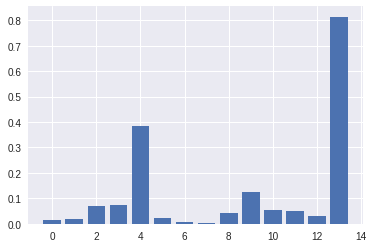

random_forest...
Best param is {'min_samples_leaf': 1, 'n_estimators': 1210} with score 0.688 on val
Score on test over random_forest: 0.678
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.64      0.72      0.68       760
           2       0.85      0.92      0.88       419
           3       0.44      0.31      0.37       302
           4       0.91      0.96      0.93       605
           5       0.44      0.42      0.43       429

    accuracy                           0.69      2572
   macro avg       0.55      0.56      0.55      2572
weighted avg       0.67      0.69      0.68      2572




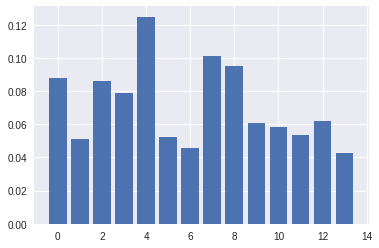

xgboost...
Best param is {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6} with score 0.698 on val
Score on test over xgboost: 0.667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.64      0.67      0.66       760
           2       0.86      0.91      0.89       419
           3       0.39      0.30      0.34       302
           4       0.90      0.96      0.93       605
           5       0.41      0.44      0.42       429

    accuracy                           0.68      2572
   macro avg       0.53      0.55      0.54      2572
weighted avg       0.66      0.68      0.67      2572




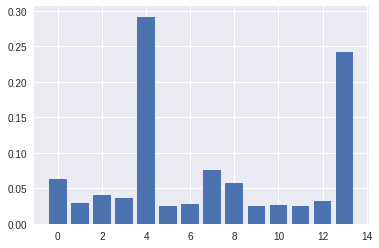


song_data finished.


6918

In [11]:
import gc
import warnings
import json

warnings.filterwarnings('ignore')


print("* * " * 25)
print('songs_dataset')
curr_dataset = Classifiers()  # initialize class
curr_dataset.set_seed()  # seed

curr_dataset_score = curr_dataset.fit_predict(df=data)
    
with open("models_result.json", "w", encoding="utf-8") as f:
    json.dump(curr_dataset_score, f, ensure_ascii=False, indent=4)
    
print("{} finished.".format('song_data'))
    
error_results = curr_dataset_score  # store to save later
    
del curr_dataset

gc.collect()